In [25]:
%load_ext autoreload
%autoreload 2

import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # Suppress TensorFlow info messages

print(sys.version)

import tensorflow as tf
print(tf.__version__)

from src.preprocessing import *
from src.display import *
from src.training import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
2.12.1


In [22]:
train_folder = "data/train"
val_folder = "data/validation"

nii_images_train = list_nii_files(train_folder, 'Flair-Brain.nii')
nii_masks_train = list_nii_files(train_folder, 'LesionSeg-Flair.nii')
nii_images_val = list_nii_files(val_folder, 'Flair-Brain.nii')
nii_masks_val = list_nii_files(val_folder, 'LesionSeg-Flair.nii')


In [23]:
images_train = load_all_data(nii_images_train)
masks_train = load_all_data(nii_masks_train)
images_val = load_all_data(nii_images_val)
masks_val = load_all_data(nii_masks_val)

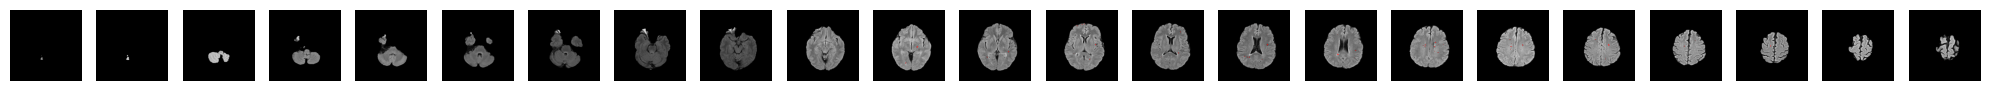

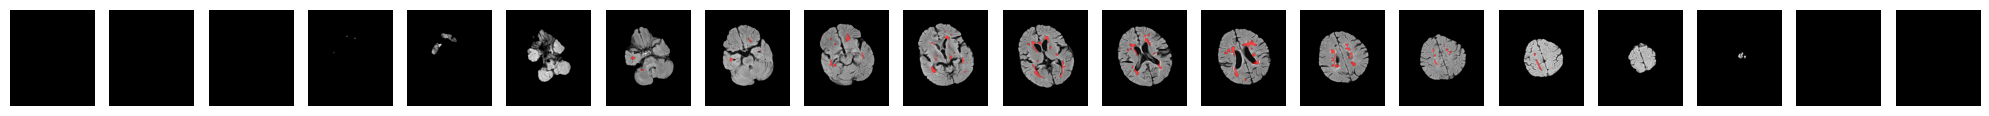

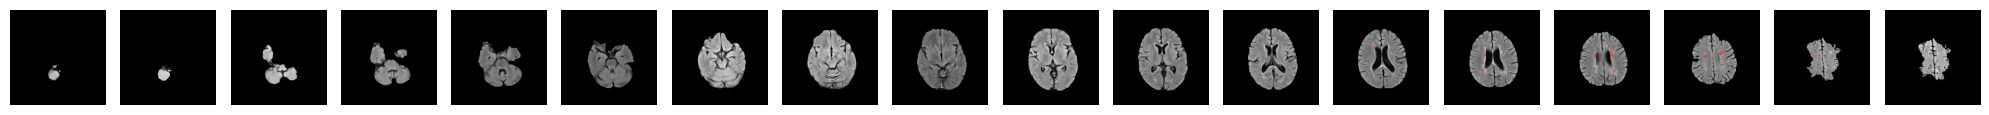

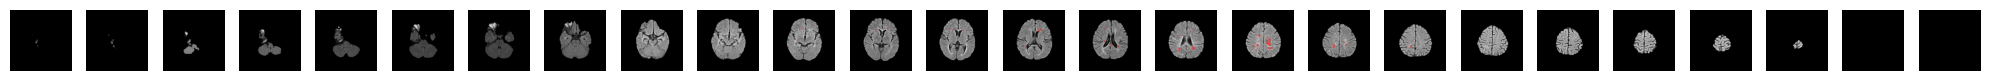

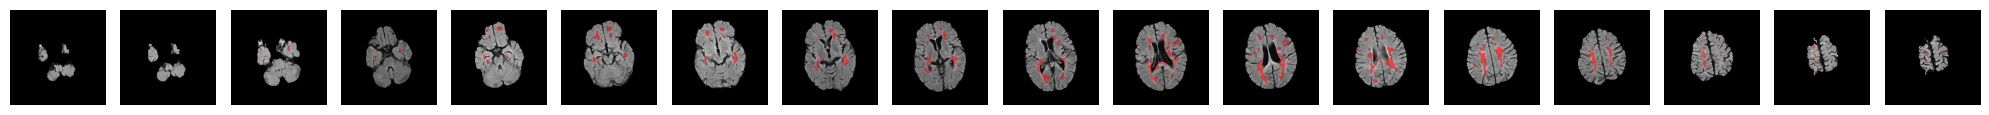

In [26]:
for i, (image, mask) in enumerate(zip(images_train[:5], masks_train[:5])):
    display_image(image, mask, rows=1)

In [5]:
resized_images_train = resize_all_images(images_train)
resized_masks_train = resize_all_images(masks_train)

resized_images_val = resize_all_images(images_val)
resized_masks_val = resize_all_images(masks_val)

# assert that the shapes are the same in mask and scan (x and y dimensions)
# for image, mask in zip(resized_images_train, resized_masks_train):
#     assert image.shape[:-1] == mask.shape[:-1]

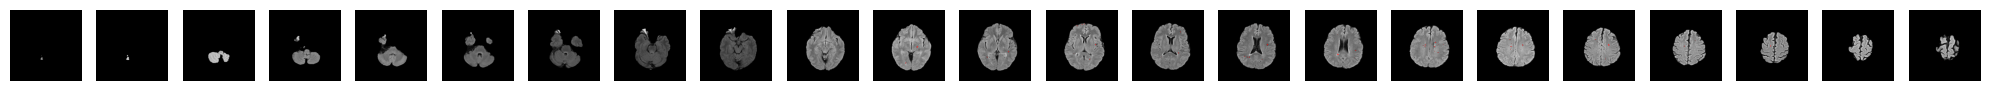

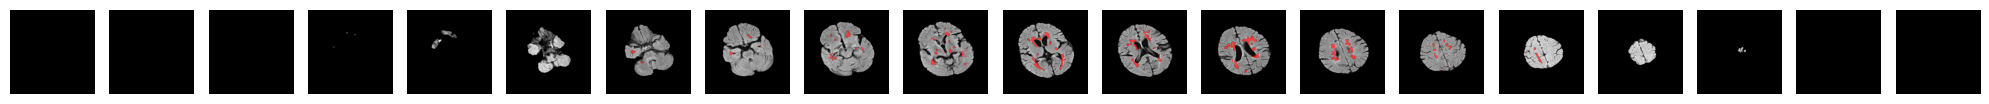

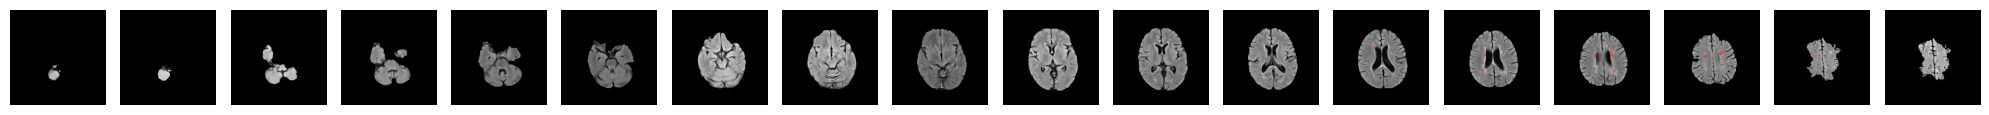

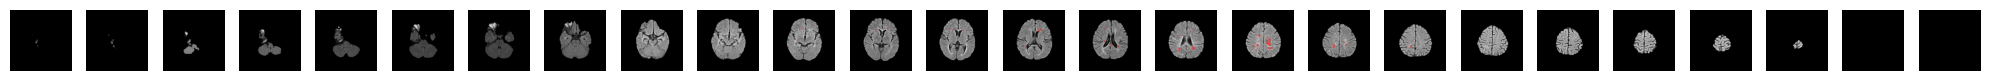

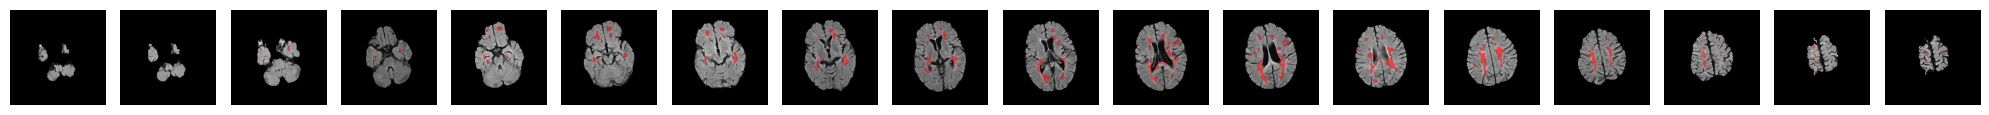

In [6]:
for i, (image, mask) in enumerate(zip(resized_images_train[:5], resized_masks_train[:5])):
    display_image(image, mask, rows=1)

In [7]:
normalized_images_train = normalize_images(resized_images_train)
normalized_images_val = normalize_images(resized_images_val)

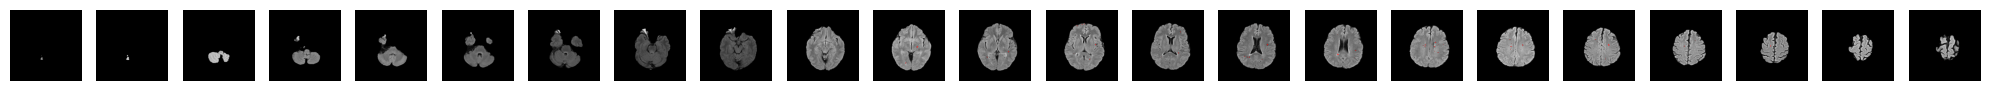

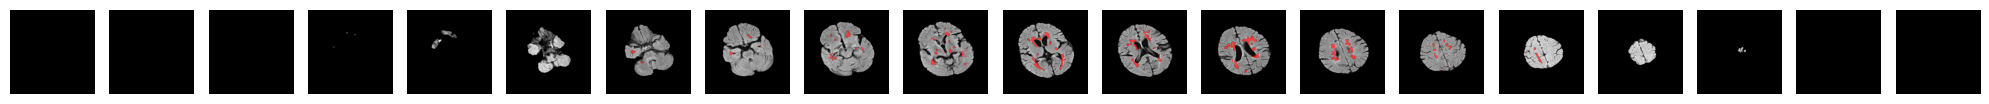

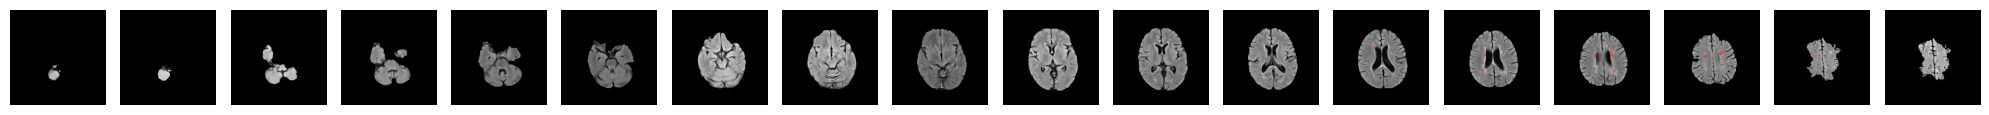

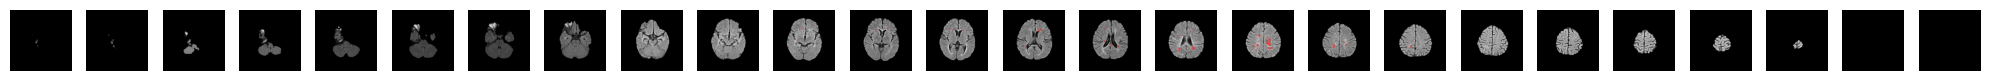

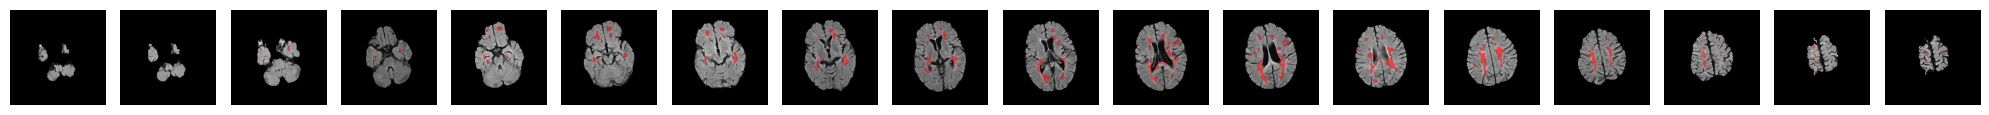

In [8]:
for i, (image, mask) in enumerate(zip(normalized_images_train[:5], resized_masks_train[:5])):
    display_image(image, mask, rows=1)

In [9]:
# Keep only slices that contain lesions
filtered_images_train, filtered_masks_train = filter_slices_with_lesions(normalized_images_train, resized_masks_train)
filtered_images_val, filtered_masks_val = filter_slices_with_lesions(resized_images_val, resized_masks_val)

# Output the number of slices remaining for each scan after filtering
for i, (filtered_image_train, filtered_mask_train) in enumerate(zip(filtered_images_train, filtered_masks_train)):
    print(f"Scan {i + 1}: {filtered_image_train.shape[-1]} slices remaining, corresponding mask shape: {filtered_mask_train.shape}")

Scan 1: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 2: 10 slices remaining, corresponding mask shape: (256, 256, 10)
Scan 3: 12 slices remaining, corresponding mask shape: (256, 256, 12)
Scan 4: 10 slices remaining, corresponding mask shape: (256, 256, 10)
Scan 5: 16 slices remaining, corresponding mask shape: (256, 256, 16)
Scan 6: 12 slices remaining, corresponding mask shape: (256, 256, 12)
Scan 7: 7 slices remaining, corresponding mask shape: (256, 256, 7)
Scan 8: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 9: 4 slices remaining, corresponding mask shape: (256, 256, 4)
Scan 10: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 11: 14 slices remaining, corresponding mask shape: (256, 256, 14)
Scan 12: 7 slices remaining, corresponding mask shape: (256, 256, 7)
Scan 13: 19 slices remaining, corresponding mask shape: (256, 256, 19)
Scan 14: 13 slices remaining, corresponding mask shape: (256, 256, 13)
Scan 15: 12 slices re

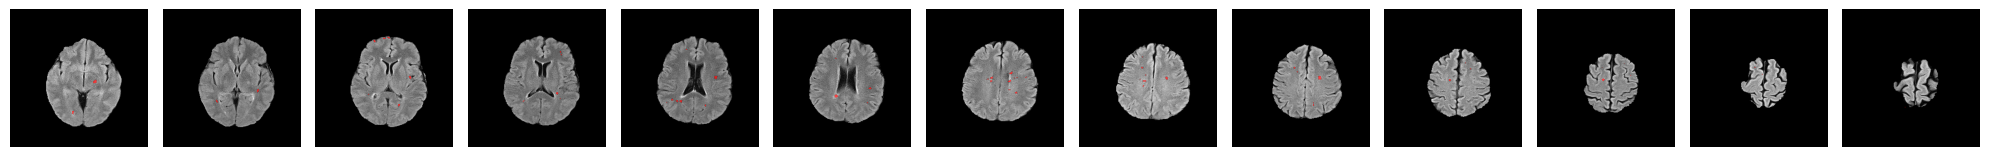

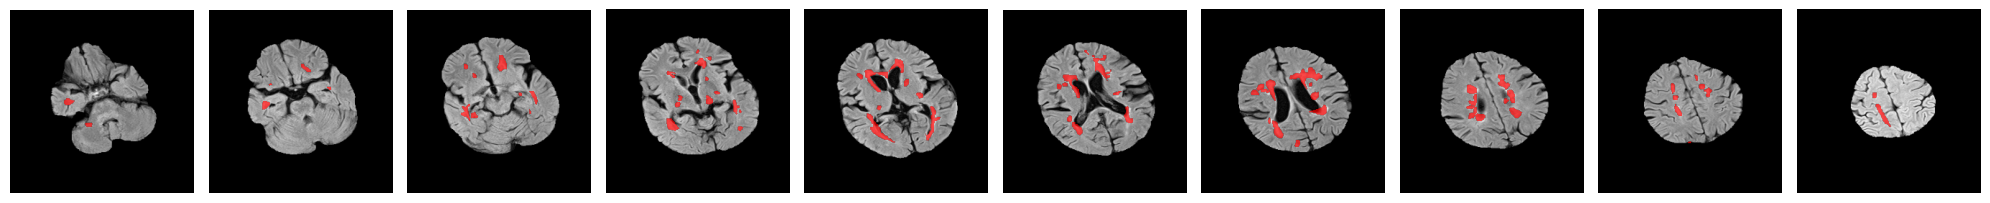

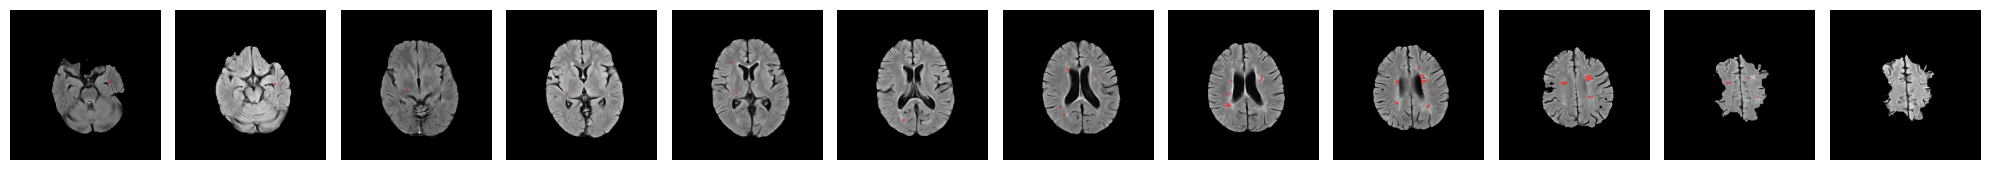

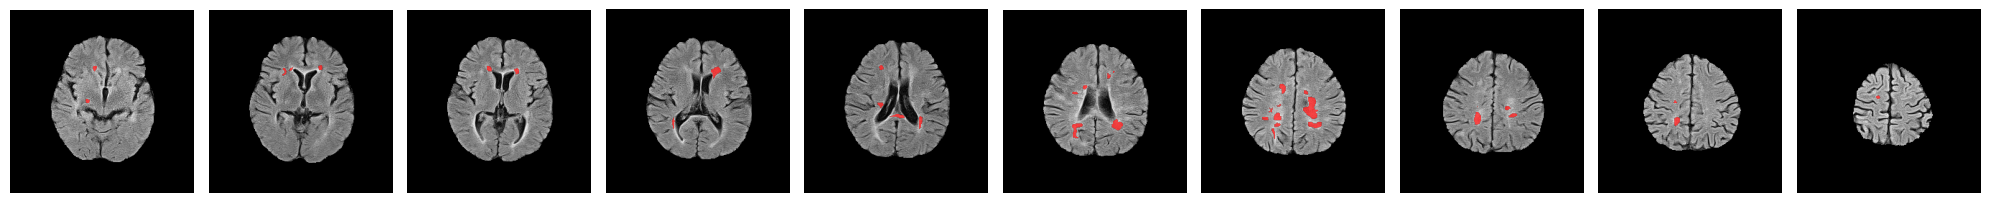

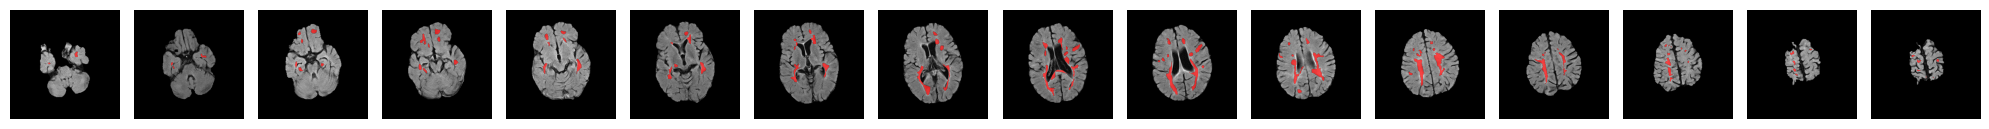

In [10]:
for i, (image, mask) in enumerate(zip(filtered_images_train[:5], filtered_masks_train[:5])):
    display_image(image, mask, rows=1)

In [11]:
# Stack 2D slices from all images
all_slices_train = stack_slices(filtered_images_train)
all_masks_train = stack_slices(filtered_masks_train)
all_slices_val = stack_slices(filtered_images_val)
all_masks_val = stack_slices(filtered_masks_val)

In [12]:
SEED = 1 # Seed to ensure the same augmentation is applied to both image and mask
BATCH_SIZE = 32

# Flow from memory
slice_iterator_train = get_augment_data_generator().flow(all_slices_train, seed=SEED, batch_size=BATCH_SIZE)
mask_iterator_train = get_augment_data_generator().flow(all_masks_train, seed=SEED, batch_size=BATCH_SIZE)

# Combined generator
iterator_train = get_combined_iterator(slice_iterator_train, mask_iterator_train)

# We probably don't want to augment the validation data?
slice_iterator_val = ImageDataGenerator().flow(all_slices_val, seed=SEED, batch_size=BATCH_SIZE)
mask_iterator_val = ImageDataGenerator().flow(all_masks_val, seed=SEED, batch_size=BATCH_SIZE)

iterator_val = get_combined_iterator(slice_iterator_val, mask_iterator_val)


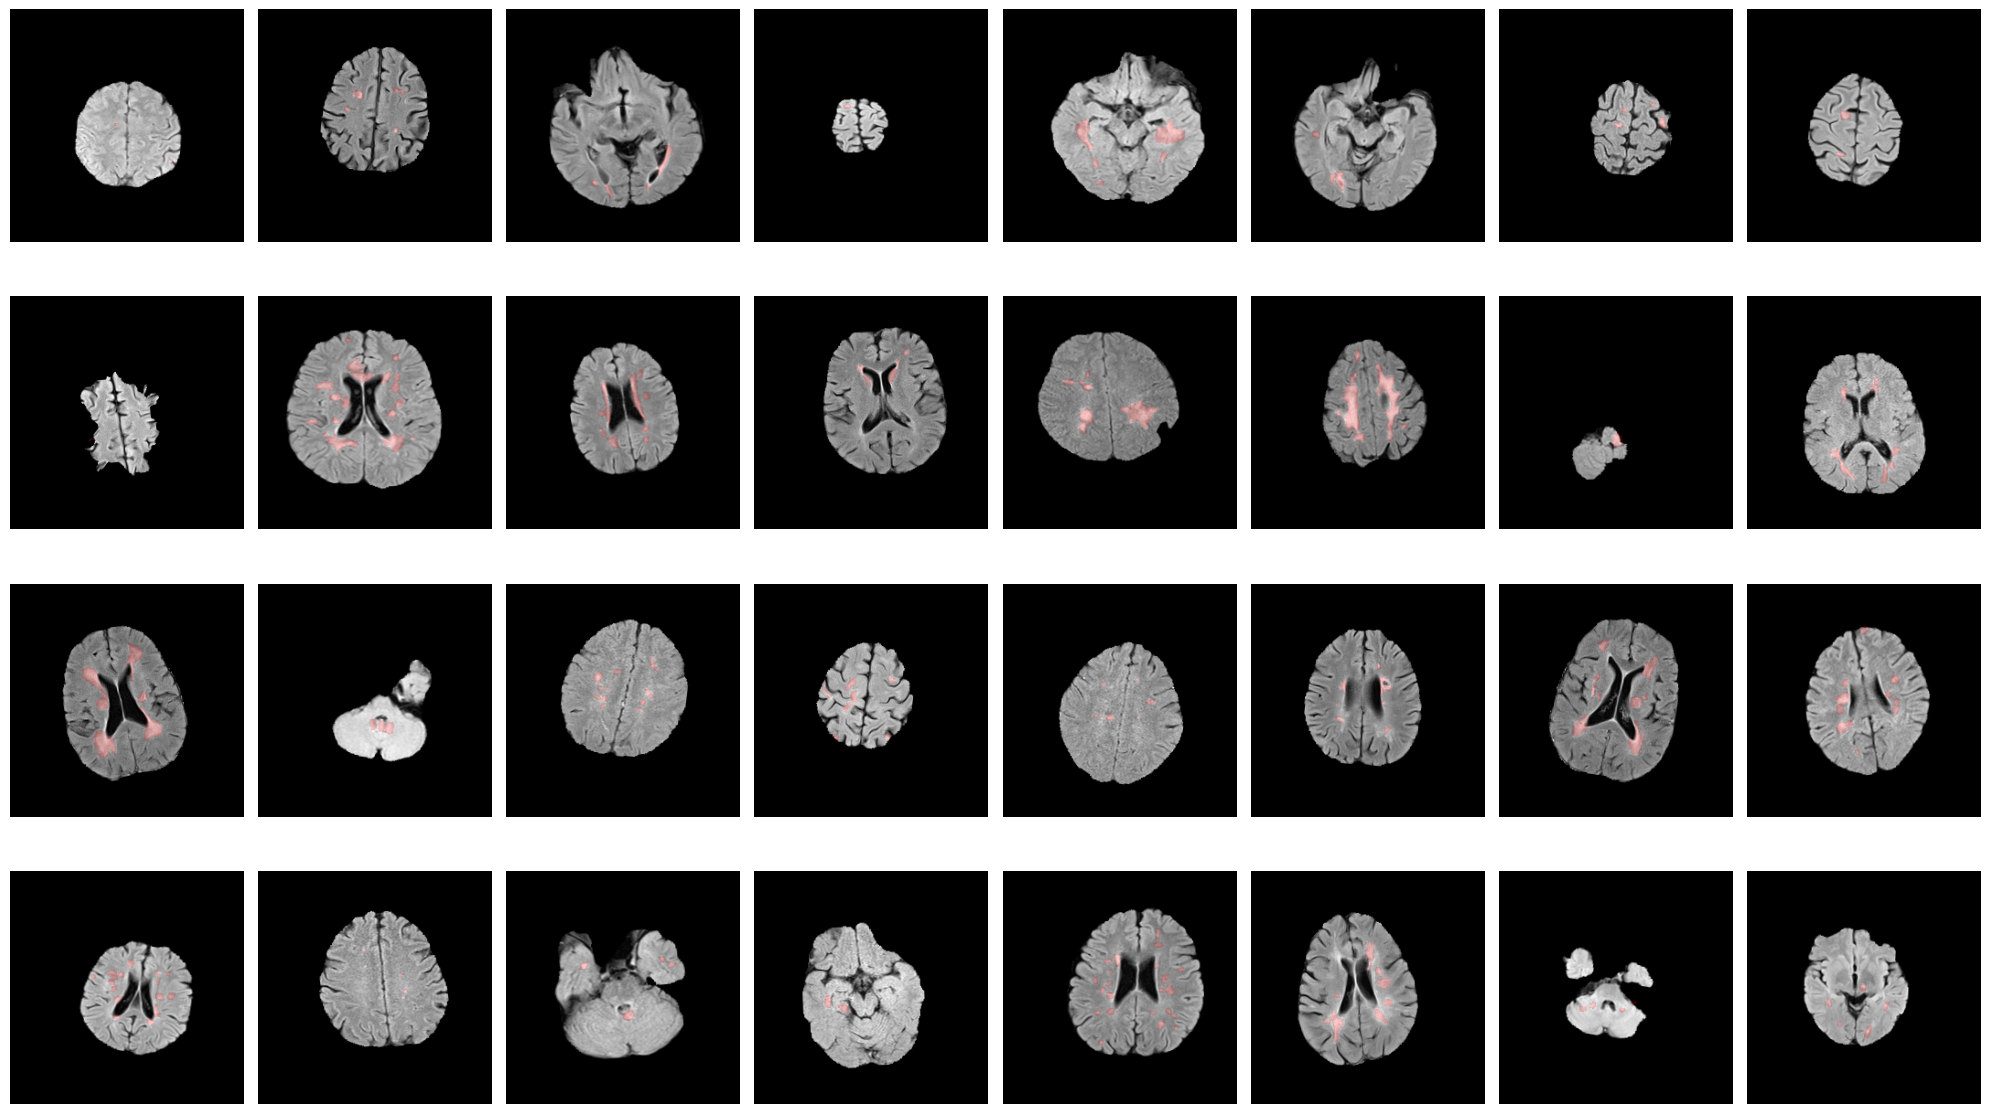

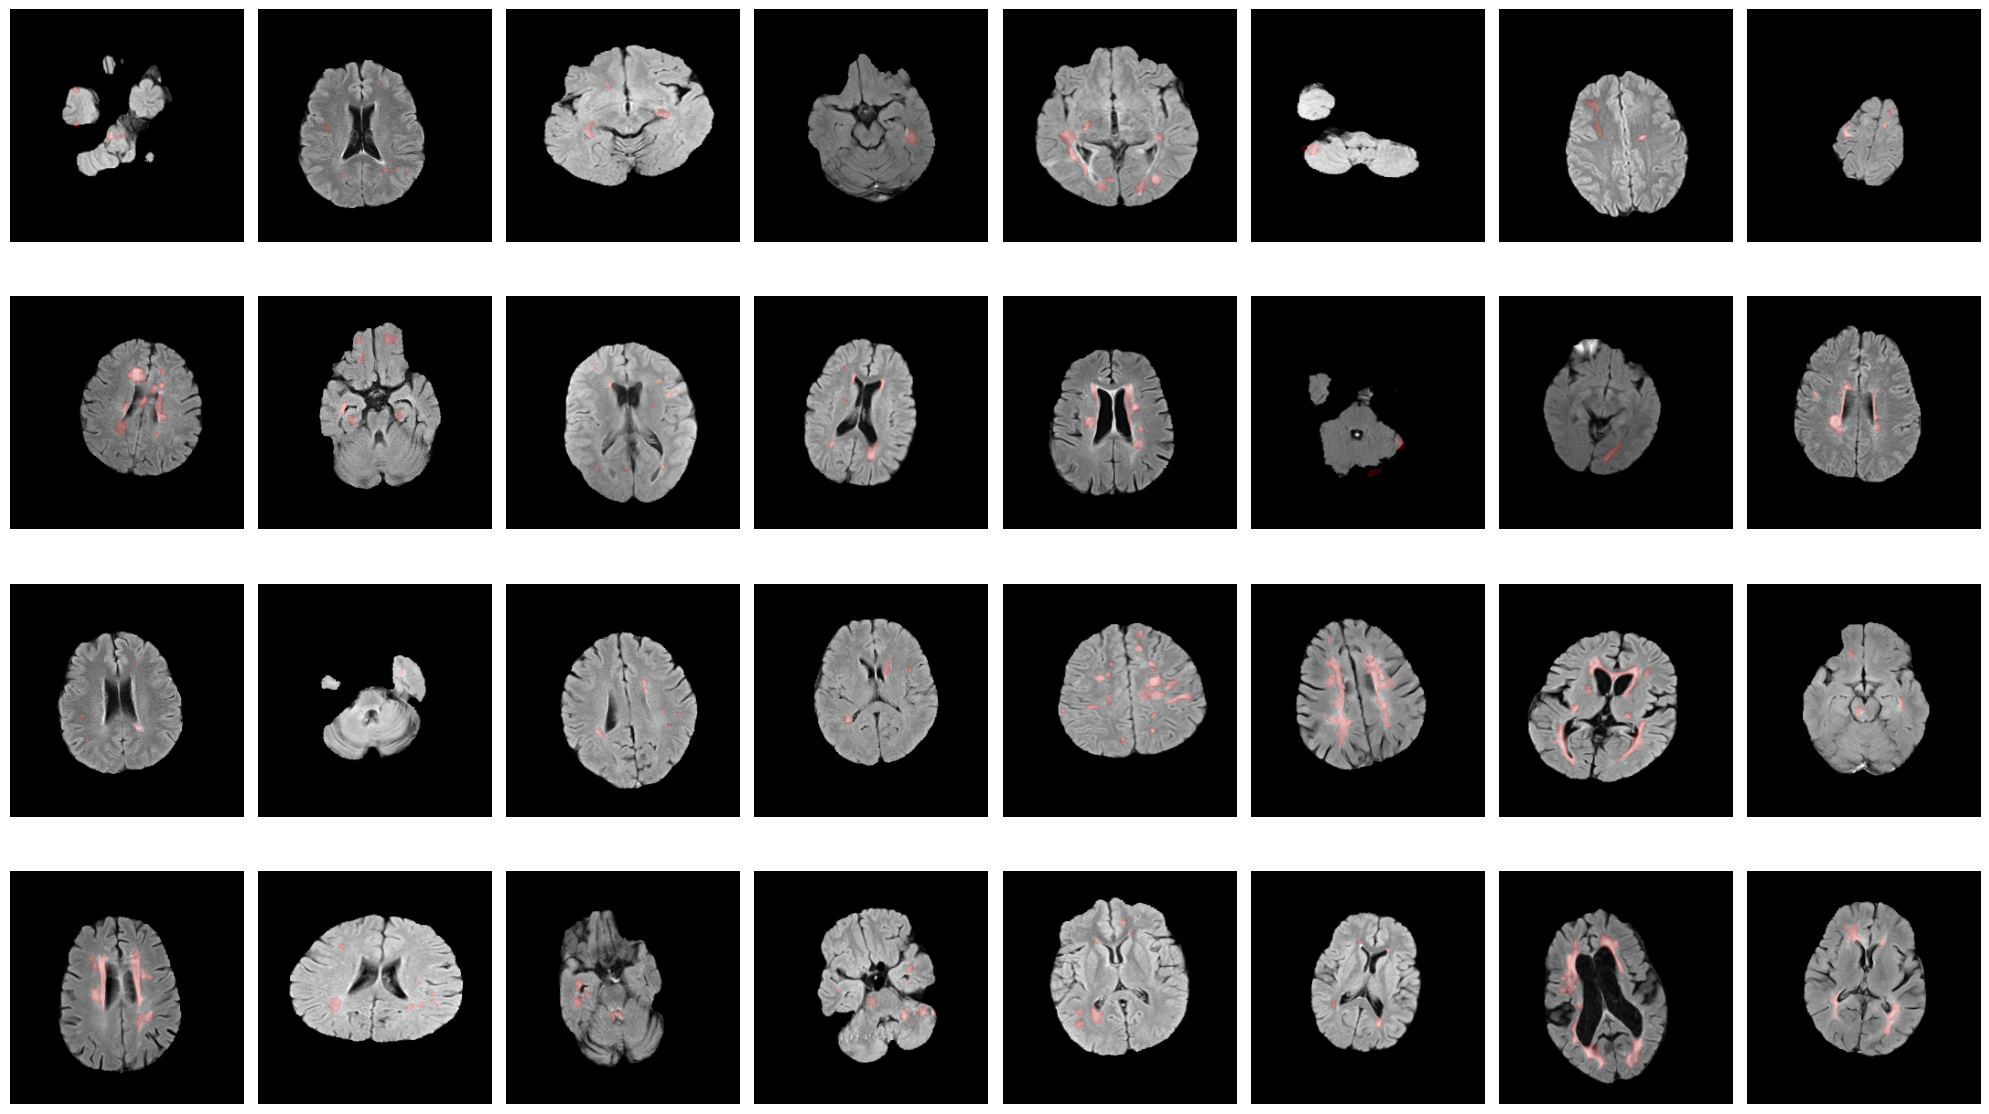

In [13]:
# Display augmented batches to check mask alignment
for n_batch in range(2):
    batch_slices, batch_masks = next(iterator_train)
    display_slices(batch_slices, batch_masks, alpha=0.2, rows=4)

In [14]:
import tensorflow as tf

tf.get_logger().setLevel('WARNING') # Suppress TensorFlow info messages

# Create and compile the model
model = build_unet_resnet50(input_shape=(256, 256, 1))
model.summary()

2024-09-14 20:10:01.471115: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 model (Functional)             [(None, 128, 128, 6  23587712    ['concatenate[0][0]']      

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=[dice_coefficient])

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_dice_coefficient', mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coefficient', factor=0.1, patience=5, mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coefficient', patience=10, mode='max', restore_best_weights=True)
]

# Train the model
history = model.fit(
    iterator_train,
    steps_per_epoch=len(all_slices_train) // BATCH_SIZE,
    validation_data=iterator_val,
    validation_steps=len(all_slices_val) // BATCH_SIZE,
    epochs=50,
    callbacks=callbacks
)

# Evaluate the model
evaluation = model.evaluate(iterator_val, steps=len(all_slices_val) // BATCH_SIZE)
print(f"Validation Loss: {evaluation[0]}")
print(f"Validation Dice Coefficient: {evaluation[1]}")

Epoch 1/50
15/15 [==============================] - 90s 5s/step - loss: 0.5910 - dice_coefficient: 0.0066 - val_loss: 0.5125 - val_dice_coefficient: 0.0147 - lr: 1.0000e-04
Epoch 2/50
15/15 [==============================] - 78s 5s/step - loss: 0.4424 - dice_coefficient: 0.1398 - val_loss: 0.4435 - val_dice_coefficient: 0.1783 - lr: 1.0000e-04
Epoch 3/50
15/15 [==============================] - 81s 5s/step - loss: 0.3254 - dice_coefficient: 0.3769 - val_loss: 0.3588 - val_dice_coefficient: 0.3264 - lr: 1.0000e-04
Epoch 4/50
15/15 [==============================] - 78s 5s/step - loss: 0.2460 - dice_coefficient: 0.5296 - val_loss: 0.2893 - val_dice_coefficient: 0.4541 - lr: 1.0000e-04
Epoch 5/50
15/15 [==============================] - 79s 5s/step - loss: 0.2260 - dice_coefficient: 0.5615 - val_loss: 0.2776 - val_dice_coefficient: 0.4795 - lr: 1.0000e-04
Epoch 6/50
15/15 [==============================] - 78s 5s/step - loss: 0.2109 - dice_coefficient: 0.5955 - val_loss: 0.2999 - val_dice

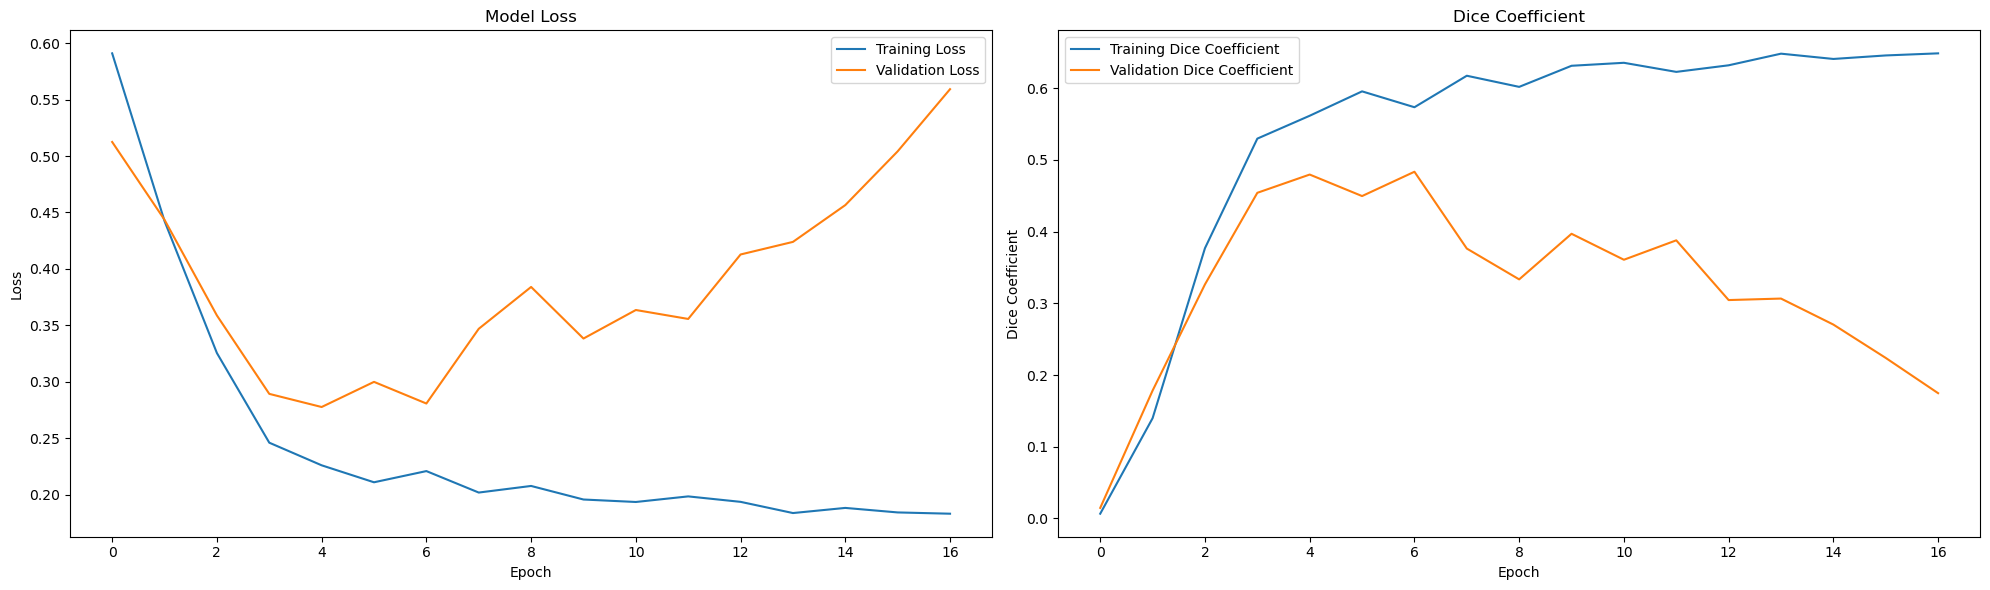

In [16]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot training history
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot dice coefficients
ax2.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
ax2.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
ax2.set_title('Dice Coefficient')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Dice Coefficient')
ax2.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [17]:
all_preds = model.predict(all_slices_val)
all_preds_binary = np.where(all_preds > 0.5, 1, 0)

5/5 [==============================] - 8s 2s/step


Display the predictions for all validation slices
- Red: Lesion mask (ground truth)
- Blue: Predicted lesion
- Yellow: Overlap

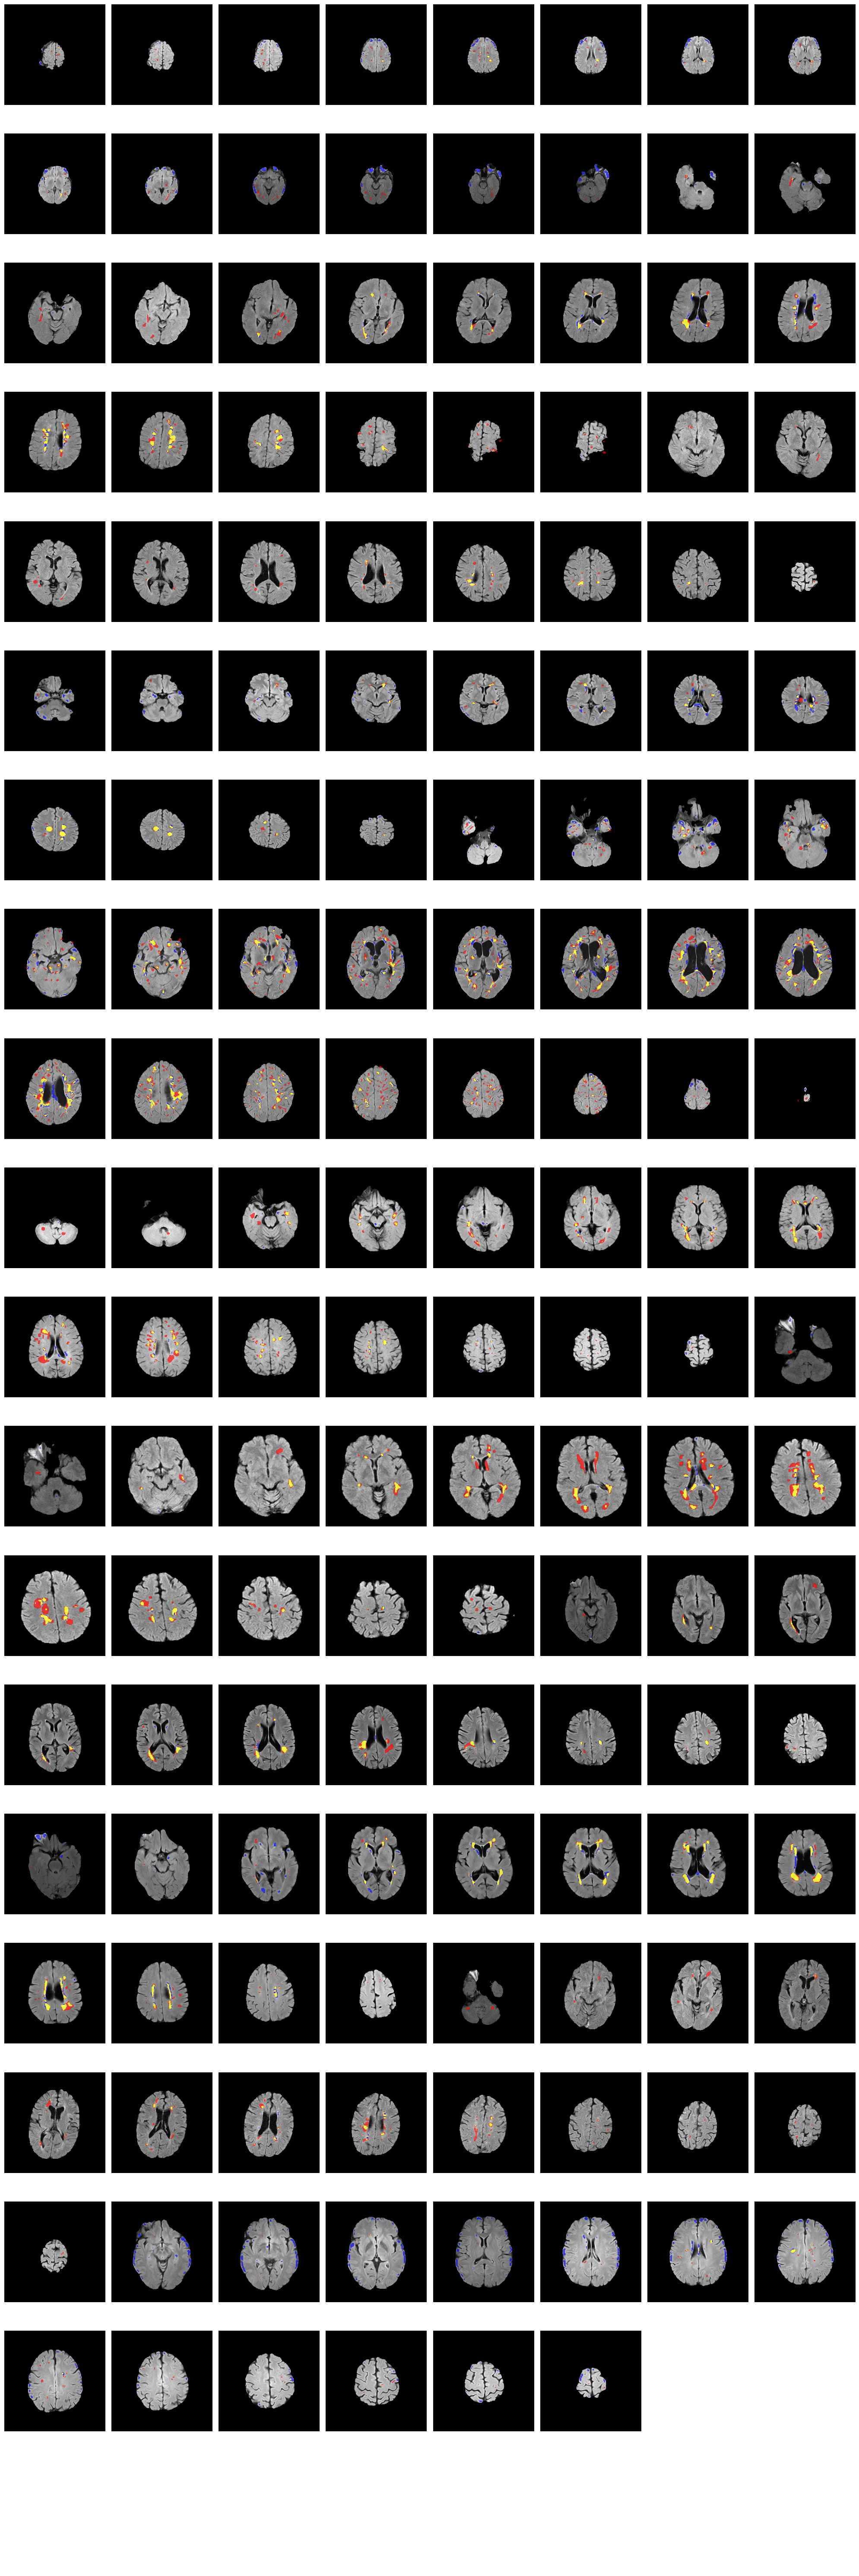

In [27]:
display_slices(all_slices_val, all_masks_val, all_preds_binary, alpha=0.7, rows=20)

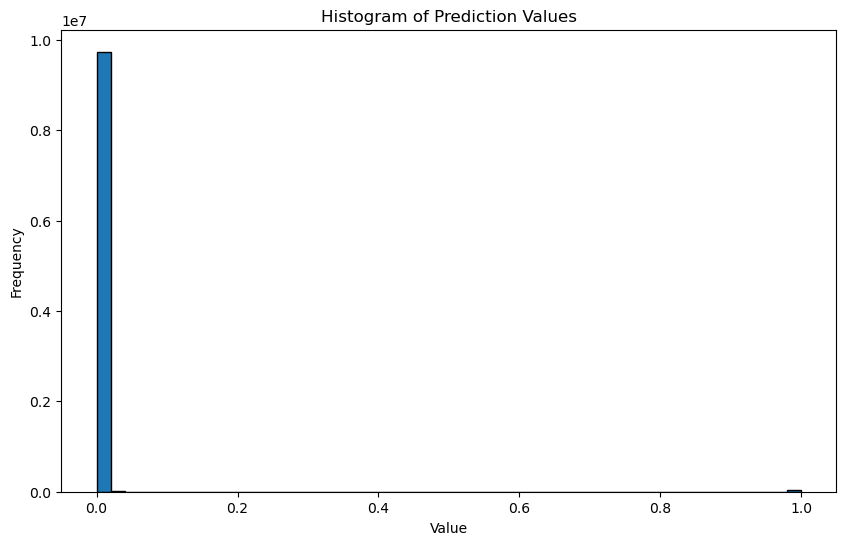

In [19]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(all_preds.flatten(), bins=50, range=(0, 1), edgecolor='black')

plt.title('Histogram of Prediction Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()